# Install all the required libraries

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima

# Data Exploration and preprocessing:

In [82]:
data=pd.read_csv(r"exchange_rate.csv", parse_dates=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [84]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [85]:
data.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [86]:
data.duplicated().sum()

0

In [87]:
data['date']=pd.to_datetime(data['date'],format='mixed')
data.set_index('date',inplace=True)

In [88]:
data.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-02-01,0.7818
1990-03-01,0.7867
1990-04-01,0.7860
1990-05-01,0.7849


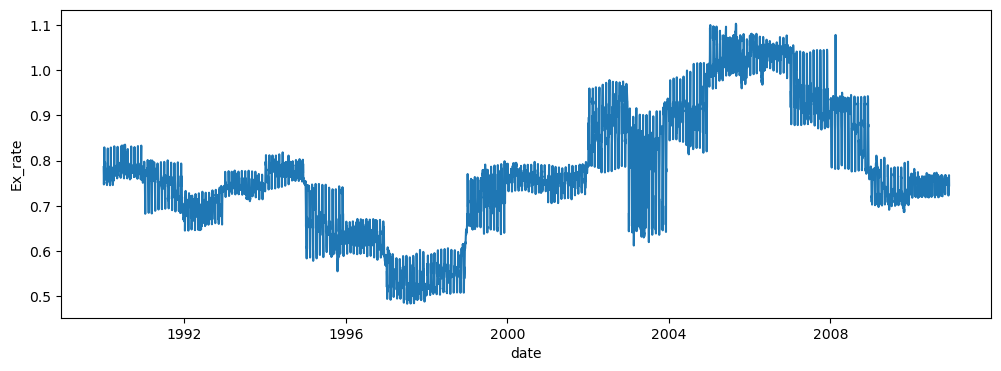

In [89]:
# lineplot of exchange rate
plt.figure(figsize=(12,4))
sns.lineplot(data['Ex_rate'])
plt.show()

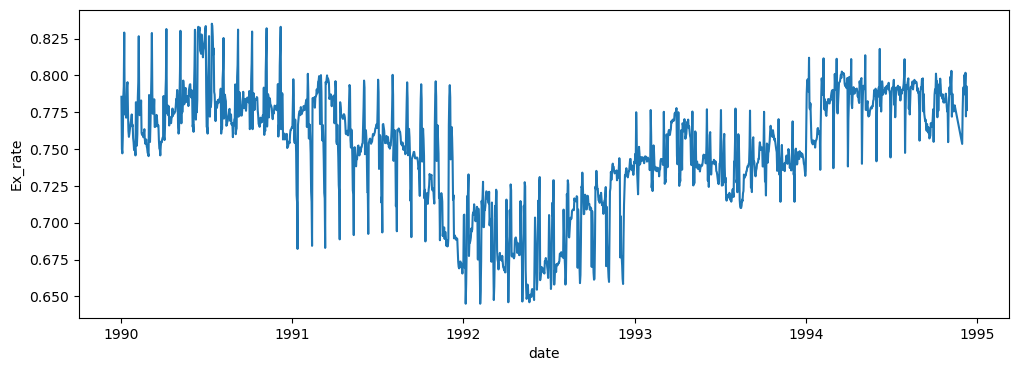

In [92]:
# lineplot of exchange rate for 5 years to evaluate seasonality
plt.figure(figsize=(12,4))
sns.lineplot(data['Ex_rate'][:1780])
plt.show()

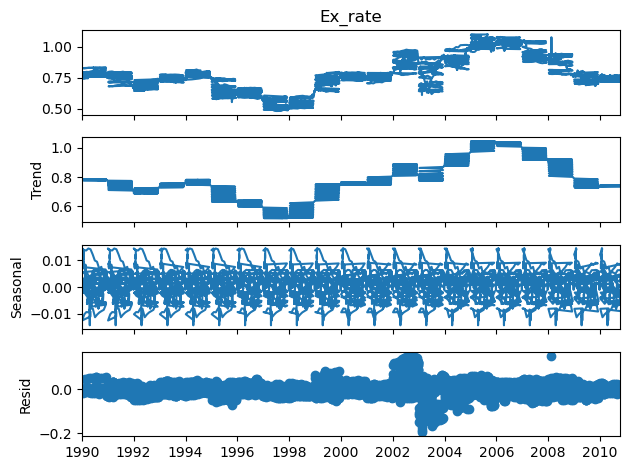

In [90]:
sd=seasonal_decompose(data['Ex_rate'],period=365)
sd.plot()
plt.show()

In [93]:
downsampled=data.resample('ME').mean()
downsampled.head()

,Ex_rate
date,
1990-01-31,0.769661
1990-02-28,0.765589
1990-03-31,0.768568
1990-04-30,0.777073
1990-05-31,0.784868


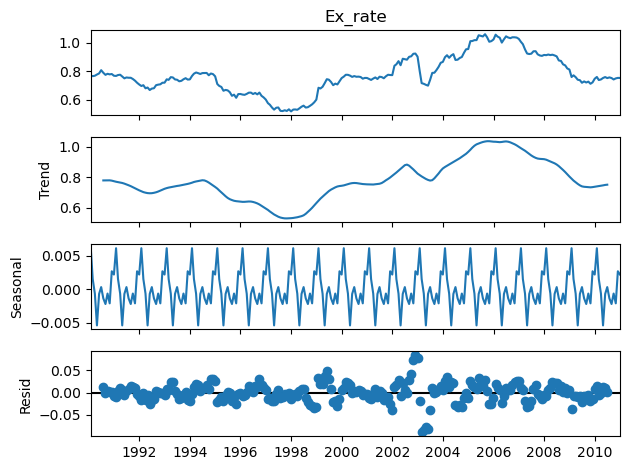

In [94]:
sd=seasonal_decompose(downsampled['Ex_rate'],period=12)
sd.plot()
plt.show()

# Apply differencing

In [95]:
# Apply non-seasonal differencing
downsampled['Ex_rate_diff'] = downsampled['Ex_rate'] - downsampled['Ex_rate'].shift(1)

# Drop NA values resulting from differencing
downsampled = downsampled.dropna()
downsampled.shape

(251, 2)

In [96]:
adf_result = adfuller(downsampled['Ex_rate_diff'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -8.590461815364506
p-value: 7.309862945662967e-14


### time series became stationary

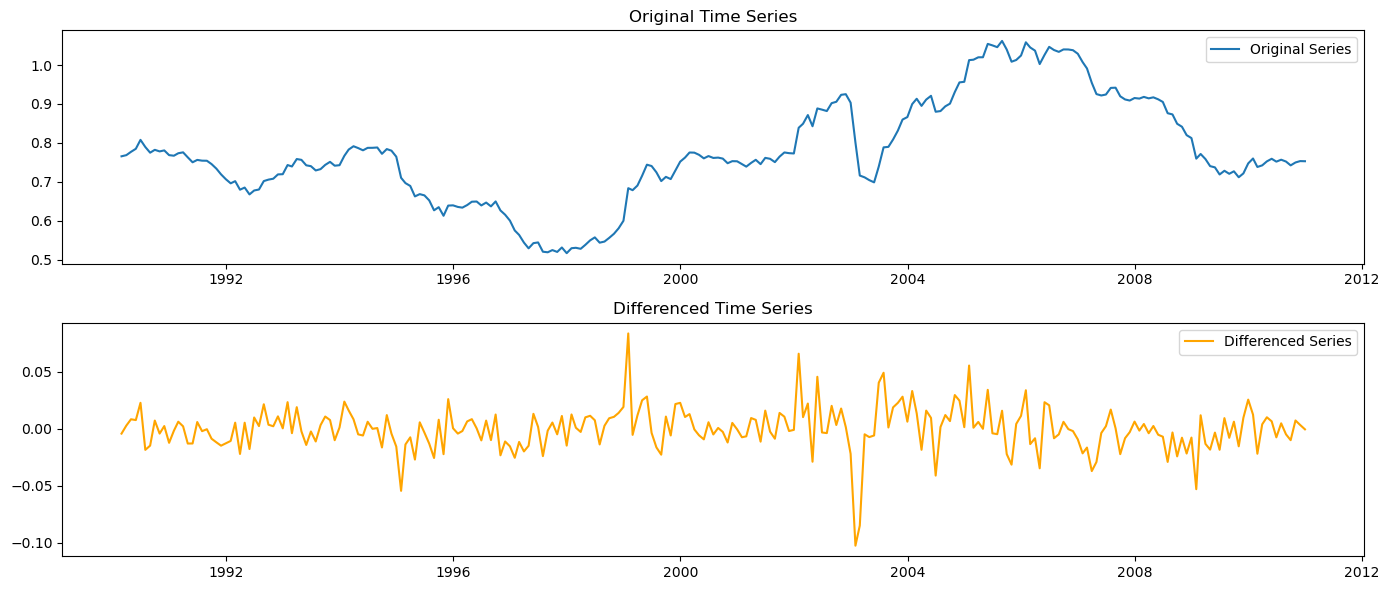

In [100]:
# Plot the original and differenced series for comparison
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(downsampled['Ex_rate'], label='Original Series')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(downsampled['Ex_rate_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
downsampled.tail()

,Ex_rate,Ex_rate_diff
date,,
2010-08-31,0.752128,-0.004702
2010-09-30,0.742300,-0.009828
2010-10-31,0.749748,0.007449
2010-11-30,0.753275,0.003526
2010-12-31,0.752940,-0.000335


In [102]:
# split the data
train=downsampled.iloc[:-12,:]
test=downsampled.iloc[-12:,:]
train.shape,test.shape

((239, 2), (12, 2))

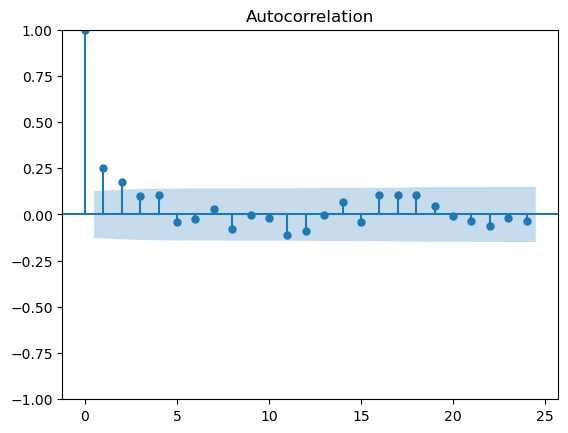

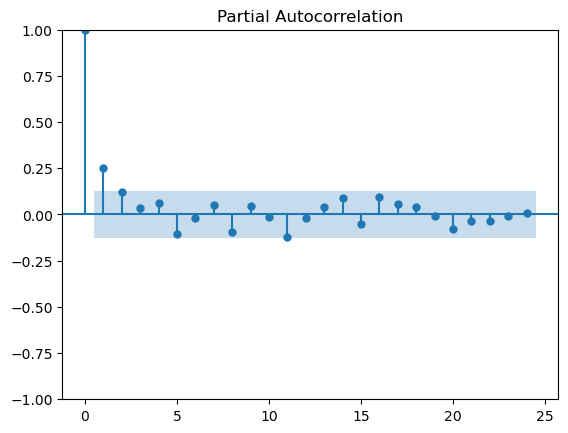

In [103]:
plot_acf(train['Ex_rate_diff'])
plot_pacf(train['Ex_rate_diff'])
plt.show()

# ARIMA

### Since the data is already stationary, applying differencing would result in over-differencing, so we set d=0.

In [104]:
model = ARIMA(train['Ex_rate_diff'], order=(1,0,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Ex_rate_diff   No. Observations:                  239
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 612.785
Date:                Mon, 14 Oct 2024   AIC                          -1217.569
Time:                        23:41:01   BIC                          -1203.663
Sample:                    02-28-1990   HQIC                         -1211.965
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.442e-05      0.002     -0.012      0.991      -0.004       0.004
ar.L1          0.6677      0.138      4.844      0.000       0.398       0.938
ma.L1         -0.4498      0.152     -2.963      0.003      -0.747      -0.152
sigma2         0.0003   1.92e-05     18.033      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               222.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
predicted_values=model_fit.fittedvalues
mape=mean_absolute_percentage_error(train['Ex_rate_diff'],predicted_values)
mape

1.551663703280867

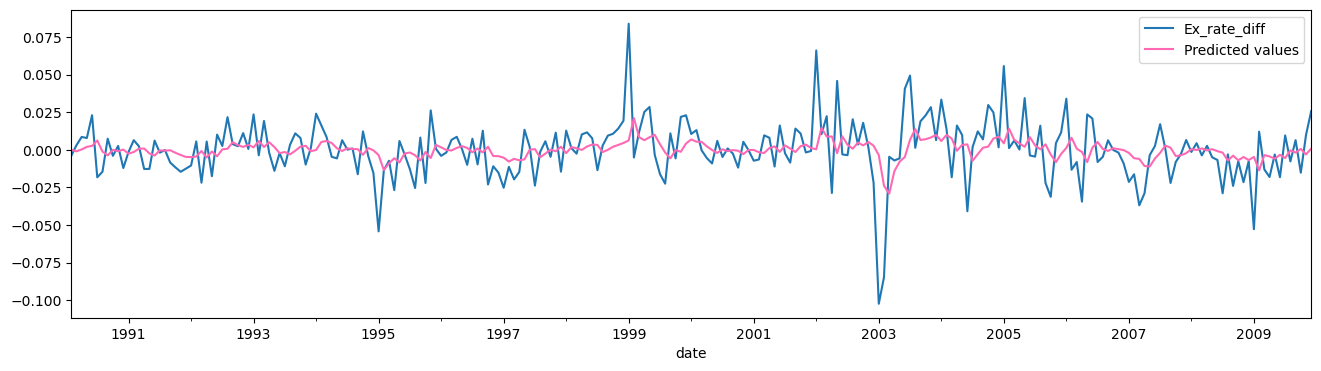

In [106]:
plt.figure(figsize=(16,4))
train['Ex_rate_diff'].plot()
model_fit.fittedvalues.plot(color='hotpink',label='Predicted values')
plt.legend() 

In [107]:
#  Get predictions for the differenced data
pred_diff = model_fit.forecast(steps=len(test))  

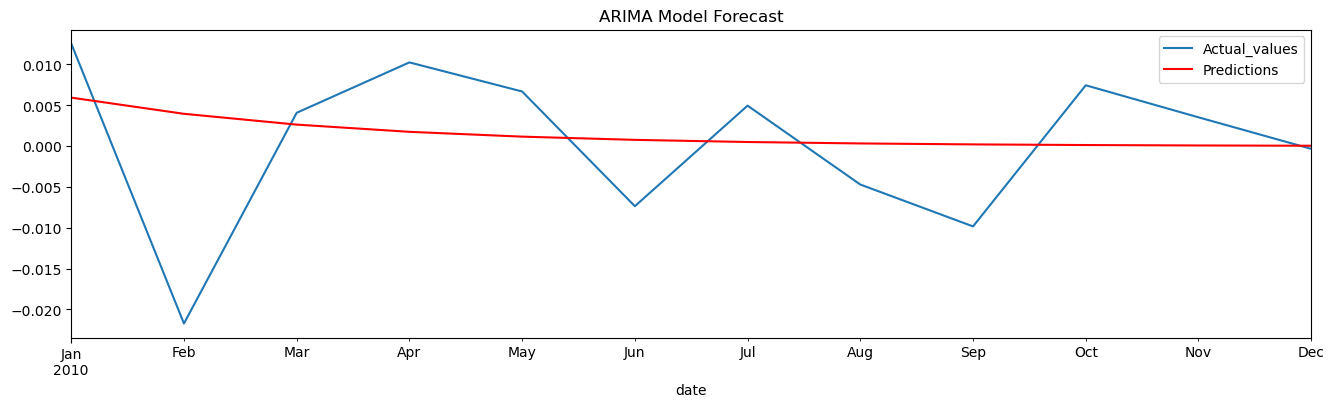

In [108]:
plt.figure(figsize=(16,4))
test['Ex_rate_diff'].plot(label='Actual_values')
pred_diff.plot(label='Predictions',color='red')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

# Sarimax

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            Ex_rate   No. Observations:                  239
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 559.848
Date:                            Mon, 14 Oct 2024   AIC                          -1109.695
Time:                                    23:49:46   BIC                          -1092.593
Sample:                                02-28-1990   HQIC                         -1102.793
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6351      0.164      3.879      0.000       0.314       0.956
ma.L1         -0.3967      0.178   

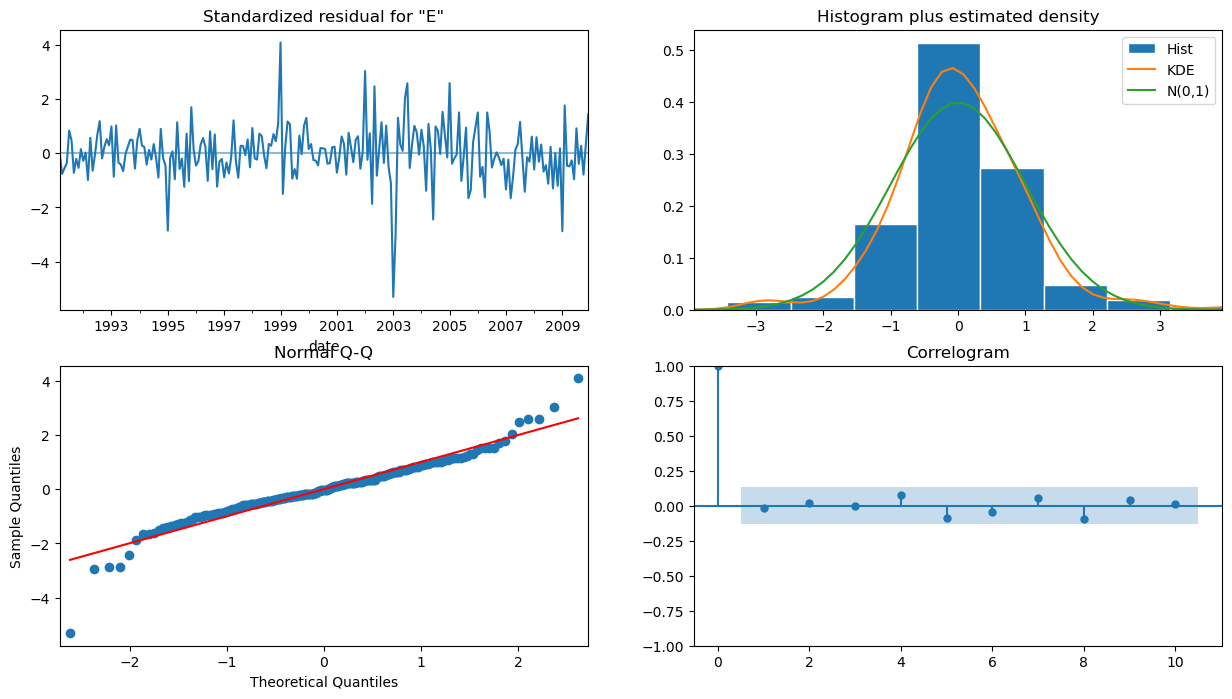

In [113]:
import statsmodels.api as sm

# order=(p,d,q), seasonal_order=(P,D,Q,m)
model = sm.tsa.SARIMAX(train['Ex_rate'], 
                       order=(1,1,1),             
                       seasonal_order=(1,1,1,12))  
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot diagnostics to check the model's performance
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

In [114]:
predicted_values=model_fit.fittedvalues
mape=mean_absolute_percentage_error(train['Ex_rate'],predicted_values)
mape

0.024557149571652767

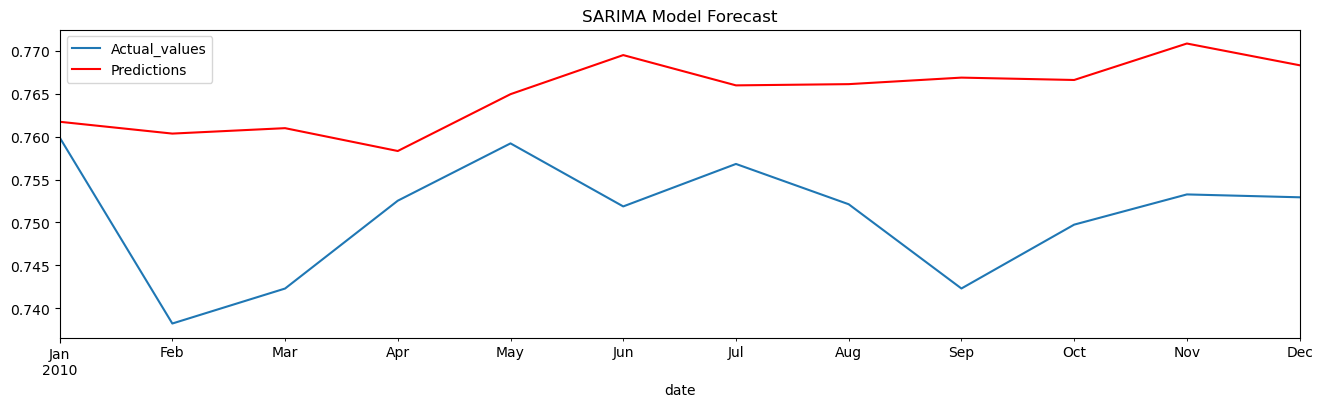

In [115]:
# Predict for the test period or future values
predictions = model_fit.forecast(steps=12)

plt.figure(figsize=(16,4))
test['Ex_rate'].plot(label='Actual_values')
predictions.plot(label='Predictions',color='red')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

# Exponential Smoothing

In [116]:
exponential_model=ExponentialSmoothing(
            train['Ex_rate'],
                seasonal='add',
                seasonal_periods=12
            ).fit()

In [117]:
predicted_values=exponential_model.fittedvalues
mape=mean_absolute_percentage_error(train['Ex_rate'],predicted_values)
mape

0.017248199770678783

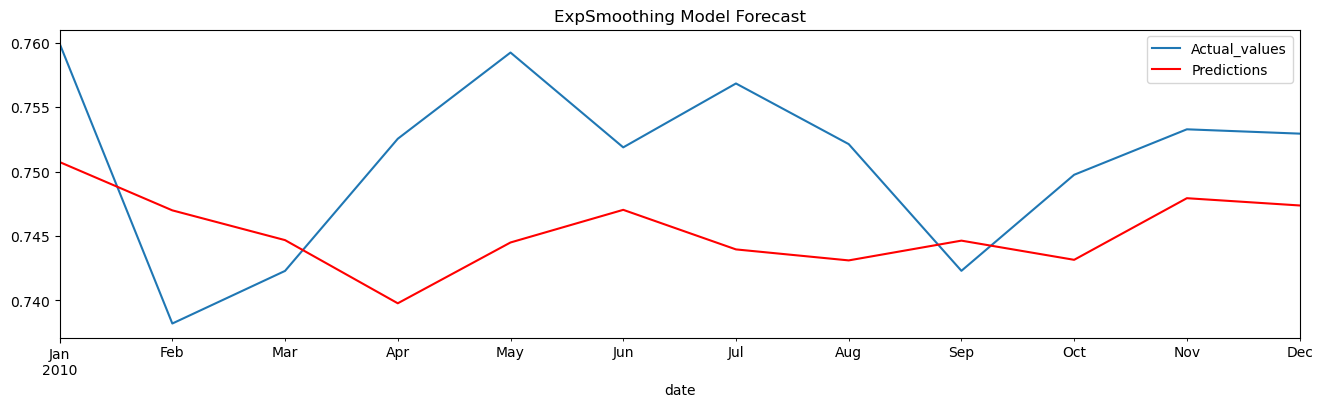

In [118]:
# Predict for the test period or future values
predictions = exponential_model.forecast(steps=12)

plt.figure(figsize=(16,4))
test['Ex_rate'].plot(label='Actual_values')
predictions.plot(label='Predictions',color='red')
plt.title('ExpSmoothing Model Forecast')
plt.legend()
plt.show()

### Among ARIMA, SARIMA, and exponential smoothing methods, exponential smoothing has yielded the best results. This is because it effectively accounts for both seasonality and trends, allowing it to model and adapt to these components more efficiently.